In [ ]:
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.models.detection.rpn import AnchorGenerator
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json

from google.colab.patches import cv2_imshow
from scipy.signal import argrelextrema

In [ ]:
def get_model(trained=True, save_path=None):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 2  # 1 class (bird) + background

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.to(device)

  if trained:
    if save_path == None: print("No path to the saved model")
    model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

  return model

def transforminput(maxsize):
    transforms = []
    # transforms.append(A.PadIfNeeded(maxsize, maxsize, border_mode=cv2.BORDER_CONSTANT))
    # transforms.append(A.Resize(576, 576))
    transforms.append(A.CenterCrop(width=576, height=576))
    return A.Compose(transforms)

def transformback(size):
    transforms = []
    transforms.append(A.Resize(size[0], size[1]))        
    transforms.append(ToTensorV2(p=1.0)) 
    return A.Compose(transforms, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

toTensor = T.Compose([T.ToTensor()])

In [ ]:
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
ROOT_DIR_SAVING = "/content/drive/MyDrive/Thesis/savedmodel/"
MODEL_NAME = "fasterrcnnv2_SGD0005_SchedulerNone_Size224_Batch8_Epoch50_8020.pth"
# ROOT_DIR_SAVING = "/content/drive/MyDrive/Thesis/savedmodel/WithCOCO/"
# MODEL_NAME = "fasterrcnn_SGD0005_SchedulerNone_Size224_Batch8_Epoch25.pth"
model = get_model(trained=True, save_path=ROOT_DIR_SAVING + MODEL_NAME)
model.eval()

def imagedetection(orig_frame):
  saved_image = orig_frame.copy()
  orig_shape = orig_frame.shape
  print(orig_shape)
  frame = cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB).astype(np.float32)
  frame /= 255.0
  frame = cv2.resize(frame, (1632, 704))
  # cv2_imshow(frame*255)
  tensorframe = toTensor(frame)
  tensorframe = tensorframe[None, ...].to(device)
  
  start = time.time()
  
  
  outputs = model(tensorframe)
  end = time.time()
  print(end - start)
  outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]


  score  = outputs[0]['scores']
  predboxes = outputs[0]['boxes']
  labels = outputs[0]["labels"].cpu().detach().numpy().astype(np.int32)
  print("Score", score)

  keepidx = torchvision.ops.nms(predboxes, score, 0.1).cpu().detach().numpy().astype(np.int32)
  score  = outputs[0]['scores'].cpu().detach().numpy()
  output = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
  score = score[keepidx]
  output = output[keepidx]
  labels = labels[keepidx]

  confidenceidx = [idx for idx, elt in enumerate(score) if elt >= 0.5]
  output = output[confidenceidx]
  score = score[confidenceidx]
  labels = labels[confidenceidx]
  print("NMSScore", score)

  area = (output[:, 3] - output[:, 1]) * (output[:, 2] - output[:, 0])
  zeroarea_filter = []
  for i in area:
      if i == 0:
          zeroarea_filter.append(False)
      else:
          zeroarea_filter.append(True)

  sample = {
      'image': frame,
      'bboxes': output[zeroarea_filter],
      'labels': labels[zeroarea_filter]
  }
  # print(outputs[0]["boxes"].cpu().detach().numpy().astype(np.int32))
  size = (orig_shape[0], orig_shape[1]) # height, width
  print(size)
  sample = transformback(size)(**sample)
  boxes = sample['bboxes']

  # loop over the boxes
  for idx, box in enumerate(boxes):
      cv2.rectangle(orig_frame,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (0, 255, 0), 2)
      cv2.putText(orig_frame, str(round(score[idx],3)), (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0), 1)

  # all_frames.append(orig_frame)
  # all_boxes.append(boxes)
  imS = cv2.resize(orig_frame, (960, 540))
  cv2_imshow(imS)
  return saved_image, boxes

# orig_frame = cv2.imread('/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/dataset/all_images/96.jpg', 0)
orig_frame = cv2.imread('/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/A5image.png', 1)
img, boxes = imagedetection(orig_frame)

(2160, 4096, 3)
(207, 284, 3)


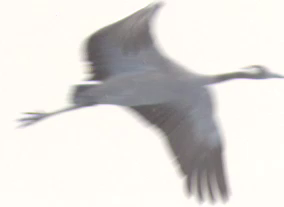

Size (207, 284, 3)


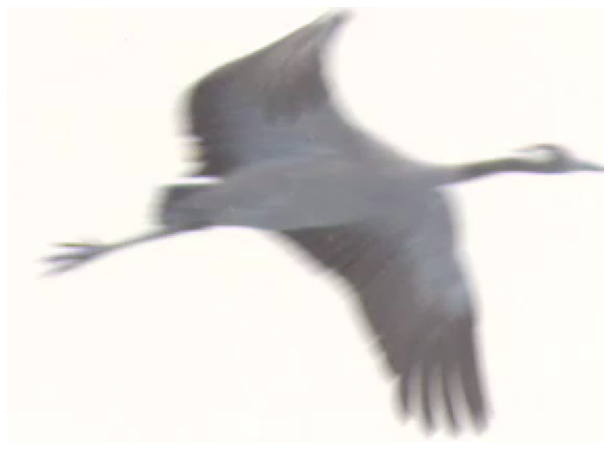

In [ ]:
coord = boxes[2]
print(img.shape)
cropped_image = img[int(coord[1]-10):int(coord[3]+10), int(coord[0]-10):int(coord[2]+10)]
print(cropped_image.shape)
cv2_imshow(cropped_image)

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# sample = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
# print("Size", sample.shape)
# # for box in boxes:
# #     cv2.rectangle(sample,
# #                 (int(box[0]), int(box[1])),
# #                 (int(box[2]), int(box[3])),
# #                 (0, 0, 255), 2)
#     # cv2.putText(sample, str(round(score[idx],3)), (int(box[0]), int(box[1])-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (1,0,0), 1)
    
# ax.imshow((sample).astype(np.uint8))
# # plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/"+str(image_id)+"area" + ".png")
# ax.axis('off')
# plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/imagerapport/imgkeypoint1.pdf", bbox_inches='tight')
# plt.show()

cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB).astype(np.float32)
# color_img = np.zeros([h, w, 3])
# color_img[:, :, 2] = cropped_image
# print(frame.shape)
# cv2_imshow(frame)

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def getidxlocalmax(c, extLeft, extRight):
  # Get the position histogram for the body axis.
  # Distance from P3 and a line formed by P1 and P2
  p3pts = c.reshape((len(c), 2))
  # print(p3pts)
  distances = []
  p1 = np.array(extLeft)
  p2 = np.array(extRight)
  for p3 in p3pts:
    d = np.abs(np.cross(p2-p1,p3-p1))/np.linalg.norm(p2-p1)
    distances.append(d)

  saveddist = distances.copy()

  #small distance first
  b = distances[np.argmin(distances)::]
  c = distances[0:np.argmin(distances)]
  distances = np.concatenate((b,c))

  # smooth the graph - !! no because cannot retrieve the corresponding point
  # distances = np.convolve(distances, np.ones(10)/10)

  # for local maxima
  idxlocalmax = argrelextrema(np.array(distances), np.greater, order=30)
  maxdistances = distances[idxlocalmax[0]]
  print(maxdistances)
  maxvalues = np.sort(maxdistances)[-2::]
  print(maxvalues)
  localmaxval1 = find_nearest(saveddist, maxvalues[0])
  localmaxval2 = find_nearest(saveddist, maxvalues[1])
  print(localmaxval1)
  print(localmaxval2)
  localmaxidx1 = np.where(saveddist==localmaxval1)[0][0]
  localmaxidx2 = np.where(saveddist==localmaxval2)[0][0]
  print(localmaxidx1)
  print(localmaxidx2)

  x = range(len(distances))
  plt.plot(x, distances)
  plt.scatter(np.array(x)[idxlocalmax[0]], np.array(distances)[idxlocalmax[0]], label="Local maximum")
  plt.ylabel("Distance (pixel)")
  plt.xlabel("Point index")
  # plt.xticks([])
  plt.legend()
  plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/imagerapport/imgkeypointhisto.pdf", bbox_inches='tight')
  plt.show()
  return [localmaxidx1, localmaxidx2]

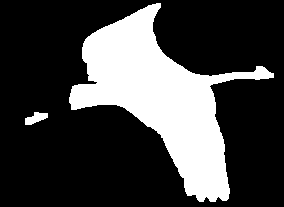

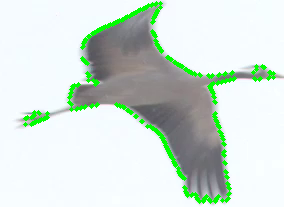

[117.82725166  85.06276747]
[ 85.06276747 117.82725166]
85.06276747054888
117.82725166028311
0
189


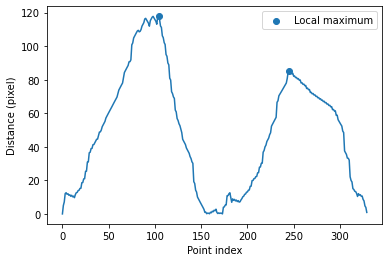

[  0 189]


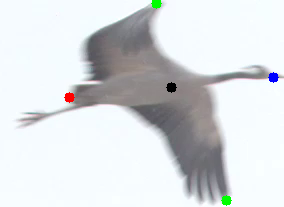

In [ ]:
# hsv_img = cv2.cvtColor(cropped_image,cv2.COLOR_RGB2HSV)  #---Converting RGB image to HSV
# hue, saturation, value, = cv2.split(hsv_img)   #---Splitting HSV image to 3 channels---
# # cv2_imshow(hue)
# # cv2_imshow(saturation)
# # cv2_imshow(value)

# blur = cv2.GaussianBlur(hue,(3,3),0)   #---Blur to smooth the edges---
# cv2_imshow(blur)

blur = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

ret,thresh = cv2.threshold(blur, 210, 255, cv2.THRESH_BINARY_INV)   #---Binary threshold---
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
cv2_imshow(thresh)

thresh = np.array(thresh * 255, dtype = np.uint8)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# for contour in contours:
copyimgg = cropped_image.copy()
for contour in cnts[0]:
  cv2.drawContours(copyimgg, contour, -1, (0, 255, 0), 3)
cv2_imshow(copyimgg)

# import scipy
# contour = contours[0].reshape((-1,2))
# print(contour)
# distances = scipy.spatial.distance.cdist(contour, contour)
# print(distances)
# print(np.unravel_index(np.argmax(distances, axis=None), distances.shape))

cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# print(c)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal

onimg = cropped_image.copy()
# cv2.drawContours(onimg, [c], -1, (0, 255, 255), 2)
cv2.circle(onimg, extLeft, 5, (0, 0, 255), -1)
cv2.circle(onimg, extRight, 5, (255, 0, 0), -1)
extCenter = (int(extLeft[0] + (extRight[0] - extLeft[0])/2), int(extLeft[1] + (extRight[1] - extLeft[1])/2))
cv2.circle(onimg, extCenter, 5, (0, 0, 0), -1)

localmaxindex = np.array(getidxlocalmax(c, extLeft, extRight))
print(localmaxindex)
cv2.circle(onimg, tuple(c.reshape((len(c), 2))[localmaxindex[0]]), 5, (0, 255, 0), -1)
cv2.circle(onimg, tuple(c.reshape((len(c), 2))[localmaxindex[1]]), 5, (0, 255, 0), -1)
# cv2.circle(onimg, extTop, 8, (255, 0, 0), -1)
# cv2.circle(onimg, extBot, 8, (255, 255, 0), -1)

# cv2.drawContours(cropped_image, [contour[[0,2]]], -1, (0, 255, 0), 3)
cv2_imshow(onimg)

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# sample = cv2.cvtColor(onimg, cv2.COLOR_BGR2RGB)
# ax.imshow((sample).astype(np.uint8))
# # plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/"+str(image_id)+"area" + ".png")
# ax.axis('off')
# plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/imagerapport/imgkeypoint5.pdf", bbox_inches='tight')
# plt.show()